# Explaining Transformers in Machine Learning
## CPE 490 590 Spring 2024
### Author: Rahul Bhadani
#### Based on work by Hunter J Philips

# 1. Tokens

In [1]:
# importing required libraries
import math
import copy
import numpy as np

# torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

# visualization packages
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

example = "Winter is coming! The air grows super crisp, and the world dons its icy cloak. Frost-kissed mornings paint the beautiful landscape in delicate hues of silver and blue."

def tokenize(sequence):
    # Split the sequence on spaces
    tokens = sequence.split(" ")

    # Remove punctuation from each token
    cleaned_tokens = []
    for token in tokens:
        # Remove trailing punctuation (if any)
        cleaned_token = token.rstrip(".,!?")
        cleaned_tokens.append(cleaned_token.lower())

    return cleaned_tokens

# Example usage:
tokenize(example)

['winter',
 'is',
 'coming',
 'the',
 'air',
 'grows',
 'super',
 'crisp',
 'and',
 'the',
 'world',
 'dons',
 'its',
 'icy',
 'cloak',
 'frost-kissed',
 'mornings',
 'paint',
 'the',
 'beautiful',
 'landscape',
 'in',
 'delicate',
 'hues',
 'of',
 'silver',
 'and',
 'blue']

## Building Vocabulary

In [2]:
def build_vocab(data):
  # tokenize the data and remove duplicates
  vocab = list(set(tokenize(data)))

  # sort the vocabulary
  vocab.sort()

  # assign an integer to each word
  stoi = {word:i for i, word in enumerate(vocab)}

  return stoi

# build the vocab
stoi = build_vocab(example)

stoi 

{'air': 0,
 'and': 1,
 'beautiful': 2,
 'blue': 3,
 'cloak': 4,
 'coming': 5,
 'crisp': 6,
 'delicate': 7,
 'dons': 8,
 'frost-kissed': 9,
 'grows': 10,
 'hues': 11,
 'icy': 12,
 'in': 13,
 'is': 14,
 'its': 15,
 'landscape': 16,
 'mornings': 17,
 'of': 18,
 'paint': 19,
 'silver': 20,
 'super': 21,
 'the': 22,
 'winter': 23,
 'world': 24}

## Construct a new sequence

In [3]:
sequence = [stoi[word] for word in tokenize("paint the world crisp and blue")]
sequence

[19, 22, 24, 6, 1, 3]

In [4]:
# def tokenize_and_map(sequence, stoi):
#     # Tokenize the input sequence
#     tokens = tokenize(sequence)

#     # Map each token to its index in the stoi dictionary
#     mapped_sequence = [stoi.get(word, -1) for word in tokens]

#     return mapped_sequence

# # Example usage:
# example = "Winter is coming! The air grows crisp, and the world dons its icy cloak. Frost-kissed mornings paint the landscape in delicate hues of silver and blue."
# sequence = tokenize_and_map("paint the world crisp and blue", stoi)
# print(sequence)

# Create Embedding Layer

In [5]:
# vocab size
vocab_size = len(stoi)

# embedding dimensions
d_model = 3

# generate the embedding layer
embeddings = torch.rand(vocab_size, d_model) # matrix of size (24, 3)
print(embeddings)

tensor([[0.3082, 0.0941, 0.2584],
        [0.5125, 0.0838, 0.0045],
        [0.2893, 0.4415, 0.4182],
        [0.1422, 0.8611, 0.8751],
        [0.3595, 0.8565, 0.0923],
        [0.1761, 0.1137, 0.5044],
        [0.3144, 0.0329, 0.5322],
        [0.2519, 0.8380, 0.6386],
        [0.4033, 0.0327, 0.7095],
        [0.0861, 0.7767, 0.1223],
        [0.1637, 0.7145, 0.4327],
        [0.6187, 0.7120, 0.7199],
        [0.1002, 0.4377, 0.6614],
        [0.4756, 0.2184, 0.9050],
        [0.2490, 0.0658, 0.9485],
        [0.1059, 0.2857, 0.4634],
        [0.2733, 0.1901, 0.9077],
        [0.1809, 0.4807, 0.7635],
        [0.4627, 0.7441, 0.0051],
        [0.1206, 0.9963, 0.8866],
        [0.3974, 0.5588, 0.8527],
        [0.8696, 0.9656, 0.6817],
        [0.2395, 0.8954, 0.6842],
        [0.3806, 0.5063, 0.1574],
        [0.6601, 0.1264, 0.2595]])


## With the embeddings created, the indexed sequence can be used to select the appropriate embedding for each token.

In [6]:
# embed the sequence
embedded_sequence = embeddings[sequence]

embedded_sequence

tensor([[0.1206, 0.9963, 0.8866],
        [0.2395, 0.8954, 0.6842],
        [0.6601, 0.1264, 0.2595],
        [0.3144, 0.0329, 0.5322],
        [0.5125, 0.0838, 0.0045],
        [0.1422, 0.8611, 0.8751]])

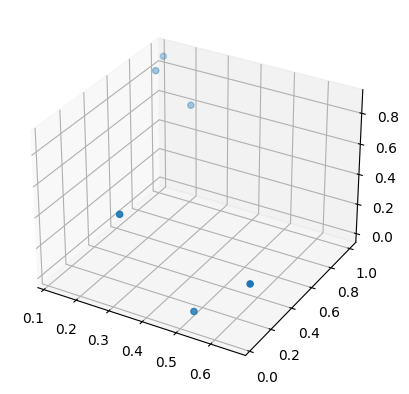

In [7]:
# visualize the embeddings in 3 dimensions
x, y, z = embedded_sequence[:, 0], embedded_sequence[:, 1], embedded_sequence[:, 2] 
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z) 

## Embeddings Using the PyTorch Module



In [8]:
# vocab size
vocab_size = len(stoi)

# embedding dimensions
d_model = 4

# create the embeddings
lut = nn.Embedding(vocab_size, d_model) # look-up table (lut)

# view the embeddings
lut.state_dict()['weight']

tensor([[ 9.4900e-01, -3.3737e-01,  2.5209e-01, -2.8580e-01],
        [-1.0575e+00,  1.6105e+00,  2.0476e+00, -9.3805e-01],
        [ 1.1577e+00, -3.2667e+00,  1.0217e+00, -6.6671e-01],
        [-2.4142e-01,  4.3843e-01,  1.4466e-01, -1.5016e+00],
        [-3.6087e-01,  5.6677e-01, -7.3604e-01,  7.8010e-01],
        [ 8.4311e-01, -8.9779e-01, -1.8664e-01,  1.3147e+00],
        [-3.5963e-01,  6.2844e-01,  5.3665e-01, -1.0837e+00],
        [-2.8043e-01,  8.7426e-01,  6.7185e-01,  2.3054e-01],
        [ 6.7681e-01, -1.8100e-01,  1.0005e+00,  1.9081e-01],
        [-8.9003e-02, -3.6998e-01, -8.9275e-01, -9.2206e-01],
        [-4.6559e-01, -3.7633e-02,  1.6081e+00, -5.1749e-01],
        [-7.4027e-02,  2.3521e+00, -4.6346e-01, -8.2612e-01],
        [-8.1356e-02,  4.3065e-01,  1.2345e-01, -3.3652e-02],
        [-2.5102e-01,  4.8565e-02, -1.7783e+00, -7.6499e-02],
        [ 1.5191e+00, -3.2277e-01,  1.0981e+00,  4.6788e-01],
        [-6.9628e-01,  3.7461e-01, -9.8974e-01, -7.9351e-01],
        

In [9]:
indices = torch.Tensor(sequence).long()

indices

tensor([19, 22, 24,  6,  1,  3])

## More than one sentences

In [10]:
# list of sequences (3, )
L = 5
sequences = ["The air grows super crisp",
             "and the world dons its.",
             "mornings paint the beautiful landscape"]

# tokenize the sequences
tokenized_sequences = [tokenize(seq) for seq in sequences]
tokenized_sequences

[['the', 'air', 'grows', 'super', 'crisp'],
 ['and', 'the', 'world', 'dons', 'its'],
 ['mornings', 'paint', 'the', 'beautiful', 'landscape']]

In [11]:
# index the sequences 
stoi = build_vocab(example)

indexed_sequences = [[stoi[word] for word in seq] for seq in tokenized_sequences]

indexed_sequences

[[22, 0, 10, 21, 6], [1, 22, 24, 8, 15], [17, 19, 22, 2, 16]]

In [12]:
# convert the sequences to a tensor
tensor_sequences = torch.tensor(indexed_sequences).long()

embedding_sequences = lut(tensor_sequences)
print(embedding_sequences.shape)
embedding_sequences


torch.Size([3, 5, 4])


tensor([[[-1.8987e-01,  2.9730e-01,  7.9158e-01, -9.6543e-01],
         [ 9.4900e-01, -3.3737e-01,  2.5209e-01, -2.8580e-01],
         [-4.6559e-01, -3.7633e-02,  1.6081e+00, -5.1749e-01],
         [ 6.0179e-01,  3.0527e-01,  6.5403e-02, -2.4042e-01],
         [-3.5963e-01,  6.2844e-01,  5.3665e-01, -1.0837e+00]],

        [[-1.0575e+00,  1.6105e+00,  2.0476e+00, -9.3805e-01],
         [-1.8987e-01,  2.9730e-01,  7.9158e-01, -9.6543e-01],
         [ 1.7666e+00, -1.5659e+00, -1.3401e-01,  1.4952e+00],
         [ 6.7681e-01, -1.8100e-01,  1.0005e+00,  1.9081e-01],
         [-6.9628e-01,  3.7461e-01, -9.8974e-01, -7.9351e-01]],

        [[ 1.3197e+00, -2.0678e+00,  1.7982e+00,  2.2491e-01],
         [-1.8582e+00, -3.0174e-03, -1.4738e+00,  8.9648e-01],
         [-1.8987e-01,  2.9730e-01,  7.9158e-01, -9.6543e-01],
         [ 1.1577e+00, -3.2667e+00,  1.0217e+00, -6.6671e-01],
         [ 2.0334e+00,  1.0505e-01, -1.1004e+00, -9.8974e-01]]],
       grad_fn=<EmbeddingBackward0>)

In [13]:
embedding_sequences.shape

torch.Size([3, 5, 4])

## The output will be a (3, 5, 4) matrix, which correlates to (batch_size, seq_length, d_model).

# Now you can create a new layer in PyTorch for Embedding

In [14]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size: int, d_model: int):
    """
    Args:
      vocab_size:     size of vocabulary
      d_model:        dimension of embeddings
    """
    # inherit from nn.Module
    super().__init__()   
     
    # embedding look-up table (lut)                          
    self.lut = nn.Embedding(vocab_size, d_model)   

    # dimension of embeddings 
    self.d_model = d_model                          

  def forward(self, x: Tensor):
    """
    Args:
      x:              input Tensor (batch_size, seq_length)
      
    Returns:
                      embedding vector
    """
    # embeddings by constant sqrt(d_model)
    return self.lut(x) * math.sqrt(self.d_model)
  

# embedding dimensions
d_model = 4

lut = Embeddings(vocab_size, d_model)

print(lut(indices))

sequences = ["The air grows crisp",
             "and the world dons.",
             "mornings paint the landscape"]

tokenized_sequences = [tokenize(seq) for seq in sequences]
print(tokenized_sequences)

indexed_sequences = [[stoi[word] for word in seq] for seq in tokenized_sequences]
print(indexed_sequences)

# convert the sequences to a tensor
tensor_sequences = torch.tensor(indexed_sequences).long()

embedding_sequences = lut(tensor_sequences)
print(embedding_sequences.shape)
print(embedding_sequences)

tensor([[ 0.1227, -0.6478, -0.2666, -0.6430],
        [-2.0183,  0.9418,  0.2368,  1.5434],
        [ 0.6513, -1.2490, -1.4104,  2.6194],
        [ 2.9200,  0.4257,  3.2847,  0.4764],
        [ 0.6979,  0.7306,  0.6418,  1.8422],
        [-2.2606,  4.7066,  2.7464,  1.4683]], grad_fn=<MulBackward0>)
[['the', 'air', 'grows', 'crisp'], ['and', 'the', 'world', 'dons'], ['mornings', 'paint', 'the', 'landscape']]
[[22, 0, 10, 6], [1, 22, 24, 8], [17, 19, 22, 16]]
torch.Size([3, 4, 4])
tensor([[[-2.0183,  0.9418,  0.2368,  1.5434],
         [-4.2355,  0.4561,  2.0146,  0.0145],
         [ 0.2239,  0.3794, -0.7963, -1.1748],
         [ 2.9200,  0.4257,  3.2847,  0.4764]],

        [[ 0.6979,  0.7306,  0.6418,  1.8422],
         [-2.0183,  0.9418,  0.2368,  1.5434],
         [ 0.6513, -1.2490, -1.4104,  2.6194],
         [-0.1647,  0.9421, -0.3210, -1.1161]],

        [[ 3.4896, -0.1044, -0.4003,  0.8868],
         [ 0.1227, -0.6478, -0.2666, -0.6430],
         [-2.0183,  0.9418,  0.2368,  1.5

# Positional Encoding

The output below embeds four sequences with a `d_model` of 4.

In [15]:
# set the output to 2 decimal places without scientific notation
torch.set_printoptions(precision=2, sci_mode=False)

# tokenize the sequences
tokenized_sequences = [tokenize(seq) for seq in sequences]

# index the sequences 
indexed_sequences = [[stoi[word] for word in seq] for seq in tokenized_sequences]

# convert the sequences to a tensor
tensor_sequences = torch.tensor(indexed_sequences).long()

# vocab size
vocab_size = len(stoi)

# embedding dimensions
d_model = 4

# create the embeddings
lut = nn.Embedding(vocab_size, d_model) # look-up table (lut)

# embed the sequence
embeddings = lut(tensor_sequences)

embeddings

tensor([[[-0.34, -0.21, -0.94, -0.54],
         [ 1.41,  1.02, -0.14, -1.56],
         [-0.18, -0.23,  0.26,  0.40],
         [ 0.31, -0.39, -0.40, -0.94]],

        [[ 1.76,  2.11,  0.86,  0.35],
         [-0.34, -0.21, -0.94, -0.54],
         [ 0.78,  1.01,  0.30, -0.61],
         [ 0.05, -0.87,  1.17,  0.58]],

        [[-0.25,  1.42, -0.69, -0.37],
         [-1.07,  0.27,  1.11,  0.27],
         [-0.34, -0.21, -0.94, -0.54],
         [-1.34,  0.93, -1.03, -0.49]]], grad_fn=<EmbeddingBackward0>)

In [16]:
# maximum sequence length
L = 5
n = 100

def gen_pe(max_length, d_model, n):

  # generate an empty matrix for the positional encodings (pe)
  pe = np.zeros(max_length*d_model).reshape(max_length, d_model) 

  # for each position
  for k in np.arange(max_length):

    # for each dimension
    for i in np.arange(d_model//2):

      # calculate the internal value for sin and cos
      theta = k / (n ** ((2*i)/d_model))       

      # even dims: sin   
      pe[k, 2*i] = math.sin(theta) 

      # odd dims: cos               
      pe[k, 2*i+1] = math.cos(theta)

  return pe



encodings = gen_pe(L, d_model, n)
print(encodings.shape)
encodings

(5, 4)


array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.09983342,  0.99500417],
       [ 0.90929743, -0.41614684,  0.19866933,  0.98006658],
       [ 0.14112001, -0.9899925 ,  0.29552021,  0.95533649],
       [-0.7568025 , -0.65364362,  0.38941834,  0.92106099]])

In [17]:
# select the first six tokens
seq_length = embeddings.shape[1]
print(seq_length)
encodings[:seq_length]

4


array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.09983342,  0.99500417],
       [ 0.90929743, -0.41614684,  0.19866933,  0.98006658],
       [ 0.14112001, -0.9899925 ,  0.29552021,  0.95533649]])

In [18]:
positional_encoding = embedding_sequences.detach().numpy() + encodings[:seq_length]
print(positional_encoding.shape)
positional_encoding

(3, 4, 4)


array([[[-2.01828671,  1.94182545,  0.23680034,  2.54340839],
        [-3.39405605,  0.99635258,  2.11443989,  1.00952852],
        [ 1.13316003, -0.03679102, -0.59763555, -0.19470044],
        [ 3.06116944, -0.56430909,  3.58022346,  1.43172649]],

       [[ 0.69792652,  1.73059303,  0.6418305 ,  2.84218454],
        [-1.17681572,  1.48212776,  0.33663376,  2.53841256],
        [ 1.560609  , -1.66510352, -1.2117245 ,  3.5994244 ],
        [-0.02359355, -0.04784393, -0.02544636, -0.16080364]],

       [[ 3.48958731,  0.89555874, -0.40029725,  1.88684362],
        [ 0.96417565, -0.10747746, -0.16681222,  0.35199224],
        [-1.10898928,  0.52567861,  0.43546967,  2.52347497],
        [ 0.65801852, -0.29632461,  0.34099757,  2.11669485]]])

## Visualize the position encoding


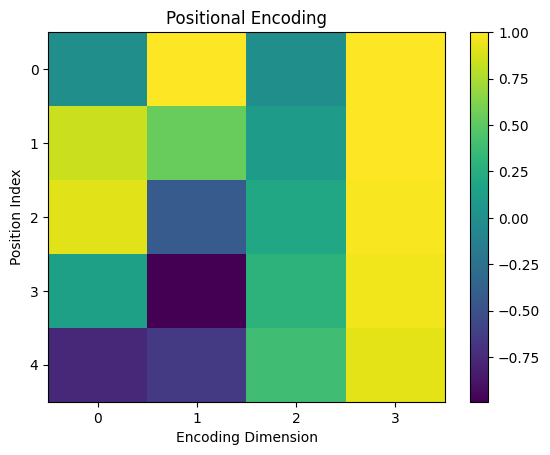

In [19]:
def visualize_pe(max_length, d_model, n):
  plt.imshow(gen_pe(max_length, d_model, n), aspect="auto")
  plt.title("Positional Encoding")
  plt.xlabel("Encoding Dimension")
  plt.ylabel("Position Index")

  # set the tick marks for the axes
  if d_model < 10:
    plt.xticks(torch.arange(0, d_model))
  if max_length < 20:
    plt.yticks(torch.arange(max_length-1, -1, -1))
    
  plt.colorbar()
  plt.show()

# plot the encodings
max_length = 5
d_model = 4
n = 100

visualize_pe(max_length, d_model, n)

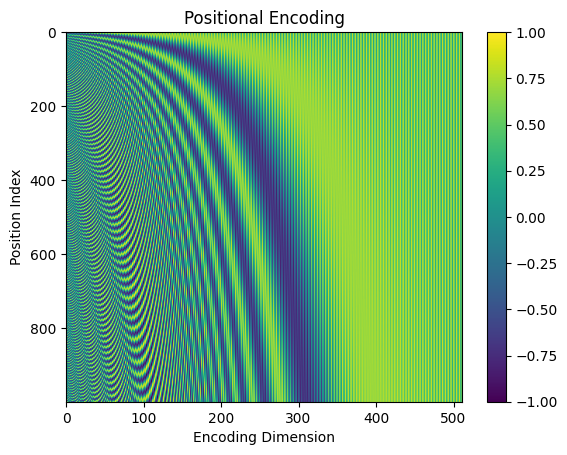

In [20]:
# plot the encodings
max_length = 1000
d_model = 512
n = 10000

visualize_pe(max_length, d_model, n)

# Now we can put together them to create a custom Layer for PositionalEncoding

In [21]:
# class PositionalEncoding(nn.Module):
#   def __init__(self, d_model: int, dropout: float = 0.1, max_length: int = 5000):
#     """
#     Args:
#       d_model:      dimension of embeddings
#       dropout:      randomly zeroes-out some of the input
#       max_length:   max sequence length
#     """
#     # inherit from Module
#     super().__init__()     

#     # initialize dropout                  
#     self.dropout = nn.Dropout(p=dropout)      

#     # create tensor of 0s
#     pe = torch.zeros(max_length, d_model)

#     # for each position
#     for k in np.arange(max_length):

#       # for each dimension
#       for i in np.arange(d_model//2):

#         # calculate the internal value for sin and cos
#         theta = k / (n ** ((2*i)/d_model))       

#         # even dims: sin   
#         pe[k, 2*i] = math.sin(theta) 

#         # odd dims: cos               
#         pe[k, 2*i+1] = math.cos(theta)

#         # buffers are saved in state_dict but not trained by the optimizer                        
#     self.register_buffer("pe", pe)                        

#   def forward(self, x: Tensor):
#     """
#     Args:
#       x:        embeddings (batch_size, seq_length, d_model)
    
#     Returns:
#                 embeddings + positional encodings (batch_size, seq_length, d_model)
#     """
#     # add positional encoding to the embeddings
#     x = x + self.pe[:, : x.size(1)].requires_grad_(False) 

#     # perform dropout
#     return self.dropout(x)
  

print(embeddings)

d_model = 4
max_length = 5
dropout = 0.0

class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_length: int = 5000):
    """
    Args:
      d_model:      dimension of embeddings
      dropout:      randomly zeroes-out some of the input
      max_length:   max sequence length
    """
    # inherit from Module
    super().__init__()     

    # initialize dropout                  
    self.dropout = nn.Dropout(p=dropout)      

    # create tensor of 0s
    pe = torch.zeros(max_length, d_model)    

    # create position column   
    k = torch.arange(0, max_length).unsqueeze(1)  

    # calc divisor for positional encoding 
    div_term = torch.exp(                                 
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )

    # calc sine on even indices
    pe[:, 0::2] = torch.sin(k * div_term)    

    # calc cosine on odd indices   
    pe[:, 1::2] = torch.cos(k * div_term)  

    # add dimension     
    pe = pe.unsqueeze(0)          

    # buffers are saved in state_dict but not trained by the optimizer                        
    self.register_buffer("pe", pe)                        

  def forward(self, x: Tensor):
    """
    Args:
      x:        embeddings (batch_size, seq_length, d_model)
    
    Returns:
                embeddings + positional encodings (batch_size, seq_length, d_model)
    """
    # add positional encoding to the embeddings
    x = x + self.pe[:, : x.size(1)].requires_grad_(False) 

    # perform dropout
    return self.dropout(x)


# create the positional encoding matrix
pe = PositionalEncoding(d_model, dropout, max_length)

# preview the values

print(pe.state_dict())

print(pe(embeddings))

tensor([[[-0.34, -0.21, -0.94, -0.54],
         [ 1.41,  1.02, -0.14, -1.56],
         [-0.18, -0.23,  0.26,  0.40],
         [ 0.31, -0.39, -0.40, -0.94]],

        [[ 1.76,  2.11,  0.86,  0.35],
         [-0.34, -0.21, -0.94, -0.54],
         [ 0.78,  1.01,  0.30, -0.61],
         [ 0.05, -0.87,  1.17,  0.58]],

        [[-0.25,  1.42, -0.69, -0.37],
         [-1.07,  0.27,  1.11,  0.27],
         [-0.34, -0.21, -0.94, -0.54],
         [-1.34,  0.93, -1.03, -0.49]]], grad_fn=<EmbeddingBackward0>)
OrderedDict([('pe', tensor([[[ 0.00,  1.00,  0.00,  1.00],
         [ 0.84,  0.54,  0.01,  1.00],
         [ 0.91, -0.42,  0.02,  1.00],
         [ 0.14, -0.99,  0.03,  1.00],
         [-0.76, -0.65,  0.04,  1.00]]]))])
tensor([[[-0.34,  0.79, -0.94,  0.46],
         [ 2.25,  1.56, -0.13, -0.56],
         [ 0.73, -0.65,  0.28,  1.39],
         [ 0.45, -1.38, -0.37,  0.06]],

        [[ 1.76,  3.11,  0.86,  1.35],
         [ 0.50,  0.33, -0.93,  0.46],
         [ 1.69,  0.60,  0.32,  0.39],
 

# Multi-head Attention

In [22]:
lut = Embeddings(vocab_size=len(stoi), d_model=4)
pe = PositionalEncoding(d_model=4, dropout=0.1, max_length=L)
embeddings = lut(tensor_sequences)
X = pe(embeddings)
print(X)
print(X.shape)

tensor([[[-1.80, -0.00, -0.87, -0.00],
         [-2.52,  1.38,  1.51,  0.43],
         [-0.00,  0.26, -2.30,  4.01],
         [-0.00, -3.70, -2.67,  0.00]],

        [[-1.10,  0.00, -1.61, -0.89],
         [-0.86, -0.71, -0.86, -0.65],
         [ 0.81, -2.06,  0.12,  2.99],
         [ 0.15,  0.79, -0.00,  0.31]],

        [[ 2.83, -0.70,  2.02, -0.84],
         [ 0.17,  4.38, -4.62,  1.32],
         [-0.79, -1.78, -0.85, -0.65],
         [ 0.26,  2.08, -1.86,  2.30]]], grad_fn=<MulBackward0>)
torch.Size([3, 4, 4])


## Let's create linear layer specifying Weights for Query, Key and Values

In [23]:
Wq = nn.Linear(d_model, d_model)          # query weights (4,4)
Wk = nn.Linear(d_model, d_model)          # key weights   (4,4)
Wv = nn.Linear(d_model, d_model)          # value weights (4,4)

Wq.state_dict()['weight']

tensor([[ 0.24,  0.32, -0.39, -0.47],
        [-0.31, -0.46, -0.33,  0.46],
        [-0.08,  0.03,  0.11,  0.21],
        [-0.09,  0.38, -0.27, -0.34]])

In [24]:
Q = Wq(X) # (3,4,4)x(broadcast 4,4) = (3,4,4)
K = Wk(X) # (3,4,4)x(broadcast 4,4) = (3,4,4)
V = Wv(X) # (3,4,4)x(broadcast 4,4) = (3,4,4)

print(Q.shape)
print(Q)

torch.Size([3, 4, 4])
tensor([[[-0.27,  0.81, -0.20,  0.15],
         [-1.13, -0.20,  0.25, -0.06],
         [-1.08,  2.46,  0.36, -0.87],
         [-0.31,  2.57, -0.63, -0.92]],

        [[ 0.61,  0.42, -0.52,  0.59],
         [ 0.03,  0.55, -0.43,  0.01],
         [-2.08,  2.00,  0.28, -2.14],
         [-0.03, -0.32, -0.18, -0.07]],

        [[-0.12, -1.67, -0.46, -1.05],
         [ 2.44,  0.02, -0.37,  2.22],
         [-0.29,  1.01, -0.46, -0.40],
         [ 0.20,  0.59,  0.07,  0.25]]], grad_fn=<ViewBackward0>)


With the Q, K, and V tensors created, they can now be split into their respective heads by changing the view of d_model to (n_heads, d_key). n_heads can be an arbitrary number, but it is common to do 8, 10, or 12 when working with larger embeddings. Remember that d_key = (d_model / n_heads).

The shape of each tensor becomes:

(batch_size, seq_length, d_model) → (batch_size, seq_length, n_heads, d_key)

We will just keep n_heads = 2

In [25]:
batch_size = Q.size(0)   
n_heads = 2
d_key = d_model//n_heads # 4/2 = 2


Q = Q.view(batch_size, -1, n_heads, d_key)

K = K.view(batch_size, -1, n_heads, d_key)

V = V.view(batch_size, -1, n_heads, d_key)                   

print(Q)
print(Q.shape)

tensor([[[[-0.27,  0.81],
          [-0.20,  0.15]],

         [[-1.13, -0.20],
          [ 0.25, -0.06]],

         [[-1.08,  2.46],
          [ 0.36, -0.87]],

         [[-0.31,  2.57],
          [-0.63, -0.92]]],


        [[[ 0.61,  0.42],
          [-0.52,  0.59]],

         [[ 0.03,  0.55],
          [-0.43,  0.01]],

         [[-2.08,  2.00],
          [ 0.28, -2.14]],

         [[-0.03, -0.32],
          [-0.18, -0.07]]],


        [[[-0.12, -1.67],
          [-0.46, -1.05]],

         [[ 2.44,  0.02],
          [-0.37,  2.22]],

         [[-0.29,  1.01],
          [-0.46, -0.40]],

         [[ 0.20,  0.59],
          [ 0.07,  0.25]]]], grad_fn=<ViewBackward0>)
torch.Size([3, 4, 2, 2])


To proceed, it would be best to transpose seq_length and n_heads, the second and third dimensions, to have the following shape:

(batch_size, seq_length, n_heads, d_key) → (batch_size, n_heads, seq_length, d_key)
Now, each sequence is split across n_heads, with each head receiving seq_length tokens with d_key elements in each token instead of d_model. This achieves the researchers’ goal to “attend to information from different representation subspaces at different positions.”

To return to the previous example, the Q tensor would be transposed from  (3, 4, 2, 2) to (3, 2, 4, 2)

In [26]:
# query tensor | (3, 4, 2, 2) to (3, 2, 4, 2)
print(Q.shape)
Q = Q.permute(0, 2, 1, 3)
# key tensor | (3, 4, 2, 2) to (3, 2, 4, 2)
K = K.permute(0, 2, 1, 3)
# value tensor | (3, 4, 2, 2) to (3, 2, 4, 2)
V = V.permute(0, 2, 1, 3)
print(Q)
print(Q.shape)

torch.Size([3, 4, 2, 2])
tensor([[[[-0.27,  0.81],
          [-1.13, -0.20],
          [-1.08,  2.46],
          [-0.31,  2.57]],

         [[-0.20,  0.15],
          [ 0.25, -0.06],
          [ 0.36, -0.87],
          [-0.63, -0.92]]],


        [[[ 0.61,  0.42],
          [ 0.03,  0.55],
          [-2.08,  2.00],
          [-0.03, -0.32]],

         [[-0.52,  0.59],
          [-0.43,  0.01],
          [ 0.28, -2.14],
          [-0.18, -0.07]]],


        [[[-0.12, -1.67],
          [ 2.44,  0.02],
          [-0.29,  1.01],
          [ 0.20,  0.59]],

         [[-0.46, -1.05],
          [-0.37,  2.22],
          [-0.46, -0.40],
          [ 0.07,  0.25]]]], grad_fn=<PermuteBackward0>)
torch.Size([3, 2, 4, 2])


In [27]:
Q[0]

tensor([[[-0.27,  0.81],
         [-1.13, -0.20],
         [-1.08,  2.46],
         [-0.31,  2.57]],

        [[-0.20,  0.15],
         [ 0.25, -0.06],
         [ 0.36, -0.87],
         [-0.63, -0.92]]], grad_fn=<SelectBackward0>)

In [28]:
# calculate scaled dot product
scaled_dot_prod = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(d_key) # (batch_size, n_heads, Q_length, K_length)

In [29]:
# apply softmax to get context for each token and others
attn_probs = torch.softmax(scaled_dot_prod, dim=-1) # (batch_size, n_heads, Q_length, K_length)

In [30]:
# def display_attention(sentence: list, translation: list, attention: Tensor, 
#                       n_heads: int = 8, n_rows: int = 4, n_cols: int = 2):
#   """
#     Display the attention matrix for each head of a sequence.

#     Args:
#         sentence:     German sentence to be translated to English; list
#         translation:  English sentence predicted by the model
#         attention:    attention scores for the heads
#         n_heads:      number of heads
#         n_rows:       number of rows
#         n_cols:       number of columns
#   """
#   # ensure the number of rows and columns are equal to the number of heads
#   assert n_rows * n_cols == n_heads
    
#   # figure size
#   fig = plt.figure(figsize=(15,20))
    
#   # visualize each head
#   for i in range(n_heads):
        
#     # create a plot
#     ax = fig.add_subplot(n_rows, n_cols, i+1)
        
#     # select the respective head and make it a numpy array for plotting
#     _attention = attention.squeeze(0)[i,:,:].cpu().detach().numpy()

#     # plot the matrix
#     cax = ax.matshow(_attention, cmap='bone')

#     # set the size of the labels
#     ax.tick_params(labelsize=12)

#     # set the indices for the tick marks
#     ax.set_xticks(range(len(sentence)))
#     ax.set_yticks(range(len(translation)))

#     ax.set_xticklabels(sentence)
#     ax.set_yticklabels(translation)

#   plt.show()

In [31]:
# # sequence 0
# display_attention(["The", "air", "grows", "crisp"], 
#                  ["The", "air", "grows", "crisp"], 
#                   attn_probs[0], 1, 1, 1)

In [32]:
# multiply attention and values to get reweighted values
A = torch.matmul(attn_probs, V) # (batch_size, n_heads, Q_length, d_key)


In [33]:
print(A.shape)
print(A)

torch.Size([3, 2, 4, 2])
tensor([[[[ 0.02,  0.33],
          [ 0.57,  0.76],
          [ 0.51,  0.72],
          [ 0.11,  0.37]],

         [[-0.36, -0.78],
          [-0.30, -0.87],
          [-0.11, -1.22],
          [-0.08, -1.29]]],


        [[[-0.18, -0.52],
          [-0.08, -0.16],
          [ 0.08,  0.36],
          [-0.12, -0.33]],

         [[-0.12, -0.78],
          [-0.20, -0.74],
          [-0.74, -0.42],
          [-0.26, -0.71]]],


        [[[-0.39, -0.50],
          [-2.29,  1.84],
          [-1.02,  0.34],
          [-1.32,  0.70]],

         [[-0.22, -0.64],
          [-0.10,  1.37],
          [-0.30, -0.14],
          [-0.35,  0.55]]]], grad_fn=<UnsafeViewBackward0>)


## Passing It Through the Output Layer

At this point, the heads can be concatenated back together before they are passed through the final linear layer, Wo in the multi-head attention mechanism.

The concatenation reverses the split that was performed originally. The first step is to transpose n_heads and Q_length. The second step is to concatenate n_heads and d_key back together to get d_model.

Once this is complete, A will have a shape of (batch_size, Q_length, d_model).



In [34]:
A = A.permute(0, 2, 1, 3).contiguous()


# reshape from (3, 4, 2, 2) -> (3, 4, 4) = (batch_size, Q_length, d_model)
A = A.view(batch_size, -1, n_heads*d_key)

print(A.shape)
print(A)

torch.Size([3, 4, 4])
tensor([[[ 0.02,  0.33, -0.36, -0.78],
         [ 0.57,  0.76, -0.30, -0.87],
         [ 0.51,  0.72, -0.11, -1.22],
         [ 0.11,  0.37, -0.08, -1.29]],

        [[-0.18, -0.52, -0.12, -0.78],
         [-0.08, -0.16, -0.20, -0.74],
         [ 0.08,  0.36, -0.74, -0.42],
         [-0.12, -0.33, -0.26, -0.71]],

        [[-0.39, -0.50, -0.22, -0.64],
         [-2.29,  1.84, -0.10,  1.37],
         [-1.02,  0.34, -0.30, -0.14],
         [-1.32,  0.70, -0.35,  0.55]]], grad_fn=<ViewBackward0>)


The final step is to pass A through Wo, which has a shape of (d_model, d_model).

In [35]:
Wo = nn.Linear(d_model, d_model)

# (3, 4, 3) x (broadcast 3, 3) = (3, 4, 3)
output = Wo(A)  
print(output)

tensor([[[-0.06, -0.72, -0.12,  0.96],
         [ 0.26, -0.69, -0.06,  0.98],
         [ 0.39, -0.81,  0.07,  1.08],
         [ 0.21, -0.85,  0.06,  1.09]],

        [[-0.15, -0.42, -0.29,  0.65],
         [-0.11, -0.52, -0.23,  0.76],
         [-0.25, -0.65, -0.28,  0.91],
         [-0.17, -0.47, -0.29,  0.70]],

        [[-0.32, -0.47, -0.30,  0.68],
         [-1.57, -1.05,  0.19,  1.25],
         [-0.71, -0.79, -0.09,  0.99],
         [-1.05, -0.73, -0.13,  0.95]]], grad_fn=<ViewBackward0>)


## Now we can create a layer to implement everything we discussed about a Multi-head Attention

In [36]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int = 512, n_heads: int = 8, dropout: float = 0.1):
    """
    Args:
        d_model:      dimension of embeddings
        n_heads:      number of self attention heads
        dropout:      probability of dropout occurring
    """
    super().__init__()
    assert d_model % n_heads == 0            # ensure an even num of heads
    self.d_model = d_model                   # 512 dim
    self.n_heads = n_heads                   # 8 heads
    self.d_key = d_model // n_heads          # assume d_value equals d_key | 512/8=64

    self.Wq = nn.Linear(d_model, d_model)    # query weights
    self.Wk = nn.Linear(d_model, d_model)    # key weights
    self.Wv = nn.Linear(d_model, d_model)    # value weights
    self.Wo = nn.Linear(d_model, d_model)    # output weights

    self.dropout = nn.Dropout(p=dropout)     # initialize dropout layer  

  def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None):
    """
    Args:
       query:         query vector         (batch_size, q_length, d_model)
       key:           key vector           (batch_size, k_length, d_model)
       value:         value vector         (batch_size, s_length, d_model)
       mask:          mask for decoder     

    Returns:
       output:        attention values     (batch_size, q_length, d_model)
       attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
    """
    batch_size = key.size(0)                  
        
    # calculate query, key, and value tensors
    Q = self.Wq(query)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)
    K = self.Wk(key)                         # (32, 10, 512) x (512, 512) = (32, 10, 512)
    V = self.Wv(value)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)

    # split each tensor into n-heads to compute attention

    # query tensor
    Q = Q.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64) 
               -1,                           # -1 = q_length
               self.n_heads,              
               self.d_key
               ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, q_length, d_key)
    # key tensor
    K = K.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64) 
               -1,                           # -1 = k_length
               self.n_heads,              
               self.d_key
               ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, k_length, d_key)
    # value tensor
    V = V.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64) 
               -1,                           # -1 = v_length
               self.n_heads, 
               self.d_key
               ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, v_length, d_key)
       
    # computes attention
    # scaled dot product -> QK^{T}
    scaled_dot_prod = torch.matmul(Q,        # (32, 8, 10, 64) x (32, 8, 64, 10) -> (32, 8, 10, 10) = (batch_size, n_heads, q_length, k_length)
                                   K.permute(0, 1, 3, 2)
                                   ) / math.sqrt(self.d_key)      # sqrt(64)
        
    # fill those positions of product as (-1e10) where mask positions are 0
    if mask is not None:
      scaled_dot_prod = scaled_dot_prod.masked_fill(mask == 0, -1e10)

    # apply softmax 
    attn_probs = torch.softmax(scaled_dot_prod, dim=-1)
        
    # multiply by values to get attention
    A = torch.matmul(self.dropout(attn_probs), V)       # (32, 8, 10, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64)
                                                        # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key) -> (batch_size, n_heads, q_length, d_key)

    # reshape attention back to (32, 10, 512)
    A = A.permute(0, 2, 1, 3).contiguous()              # (32, 8, 10, 64) -> (32, 10, 8, 64)
    A = A.view(batch_size, -1, self.n_heads*self.d_key) # (32, 10, 8, 64) -> (32, 10, 8*64) -> (32, 10, 512) = (batch_size, q_length, d_model)
        
    # push through the final weight layer
    output = self.Wo(A)                                 # (32, 10, 512) x (512, 512) = (32, 10, 512) 

    return output, attn_probs                           # return attn_probs for visualization of the scores

In [37]:
torch.set_printoptions(precision=2, sci_mode=False)


# embedding dimensions
d_model = 4

# create the embeddings
lut = Embeddings(vocab_size, d_model) # look-up table (lut)

# create the positional encodings
pe = PositionalEncoding(d_model=d_model, dropout=0.1, max_length=L)

# embed the sequence
embeddings = lut(tensor_sequences)

# positionally encode the sequences
X = pe(embeddings)

# set the n_heads
n_heads = 2

# create the attention layer
attention = MultiHeadAttention(d_model, n_heads, dropout=0.1)

# pass X through the attention layer three times to create Q, K, and V
output, attn_probs = attention(X, X, X, mask=None)

output

tensor([[[    -0.50,      0.79,      1.13,     -0.28],
         [    -0.00,      1.07,      1.06,     -0.40],
         [    -0.60,      0.49,      0.95,     -0.10],
         [    -0.13,      0.83,      1.08,     -0.32]],

        [[    -0.48,      1.52,      1.07,      0.23],
         [    -0.78,      1.36,      1.02,      0.49],
         [    -0.65,      0.86,      1.18,      0.14],
         [     0.02,      0.53,     -0.11,      0.58]],

        [[    -0.12,      1.25,      1.07,      0.03],
         [     0.77,      2.05,      0.27,      0.18],
         [    -0.32,      0.38,      0.70,      0.26],
         [     0.74,      1.71,      0.31,     -0.02]]],
       grad_fn=<ViewBackward0>)

# Position-wise Feed-forward Network

The Position-Wise Feed-Forward Network (FFN) consists of two fully connected dense layers, or a multi-layer perceptron (MLP). The hidden layer, which is known as d_ffn, is generally set to a value about four times that of d_model. This is why it is sometimes known as an expand-and-contract network.

According to d2l, it is known as a “position-wise” network because it “transforms the representation at all the sequence positions using the same MLP.”

The ReLU activiation function, max(0, X), is used between the layers. Any values greater than 0 remain the same, and any values less than or equal to 0 become 0. It introduces non-linearity and helps prevent vanishing gradients.

In [38]:
d_ffn = d_model * 4  # 4

w_1 = nn.Linear(d_model, d_ffn)  # (1, 4)
w_2 = nn.Linear(d_ffn, d_model)  # (4, 1)

ffn_1 = w_1(output).relu()
print(ffn_1.shape)
print(ffn_1)

torch.Size([3, 4, 16])
tensor([[[0.66, 0.49, 0.00, 1.17, 0.00, 0.13, 0.56, 0.06, 0.07, 0.26, 0.25,
          0.00, 0.00, 0.28, 0.49, 0.00],
         [0.63, 0.51, 0.00, 1.32, 0.00, 0.40, 0.88, 0.00, 0.02, 0.25, 0.33,
          0.00, 0.00, 0.09, 0.79, 0.00],
         [0.67, 0.50, 0.00, 0.92, 0.00, 0.00, 0.36, 0.05, 0.07, 0.13, 0.20,
          0.04, 0.00, 0.35, 0.28, 0.00],
         [0.65, 0.53, 0.00, 1.21, 0.00, 0.28, 0.73, 0.00, 0.06, 0.19, 0.26,
          0.00, 0.00, 0.15, 0.66, 0.00]],

        [[0.97, 0.53, 0.00, 1.17, 0.15, 0.41, 1.06, 0.00, 0.03, 0.70, 0.62,
          0.00, 0.00, 0.05, 0.77, 0.00],
         [1.06, 0.54, 0.00, 0.97, 0.11, 0.25, 0.89, 0.00, 0.05, 0.72, 0.62,
          0.00, 0.00, 0.13, 0.56, 0.00],
         [0.87, 0.56, 0.00, 1.03, 0.00, 0.16, 0.67, 0.04, 0.12, 0.43, 0.36,
          0.00, 0.00, 0.22, 0.49, 0.00],
         [0.80, 0.56, 0.00, 0.22, 0.00, 0.03, 0.51, 0.00, 0.00, 0.00, 0.43,
          0.00, 0.03, 0.12, 0.18, 0.00]],

        [[0.86, 0.57, 0.00, 1.19, 0.0

Then, the tensor can be passed through the second dense layer to return to its normal size

In [39]:
ffn_2 = w_2(ffn_1)
print(ffn_2.shape)
print(ffn_2)

torch.Size([3, 4, 4])
tensor([[[     0.00,     -0.46,      0.31,     -0.55],
         [    -0.02,     -0.68,      0.38,     -0.71],
         [    -0.01,     -0.30,      0.24,     -0.40],
         [    -0.01,     -0.58,      0.35,     -0.61]],

        [[    -0.09,     -0.64,      0.32,     -0.92],
         [    -0.10,     -0.50,      0.27,     -0.85],
         [    -0.04,     -0.46,      0.29,     -0.66],
         [    -0.16,     -0.19,      0.13,     -0.40]],

        [[    -0.07,     -0.68,      0.35,     -0.84],
         [    -0.14,     -0.73,      0.27,     -0.95],
         [    -0.06,     -0.29,      0.20,     -0.41],
         [    -0.12,     -0.69,      0.31,     -0.85]]],
       grad_fn=<ViewBackward0>)


## We can create a new layer combining everything in the position-wise feed-forward layer

In [40]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model: int, d_ffn: int, dropout: float = 0.1):
    """
    Args:
        d_model:      dimension of embeddings
        d_ffn:        dimension of feed-forward network
        dropout:      probability of dropout occurring
    """
    super().__init__()

    self.w_1 = nn.Linear(d_model, d_ffn)
    self.w_2 = nn.Linear(d_ffn, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Args:
        x:            output from attention (batch_size, seq_length, d_model)
       
    Returns:
        expanded-and-contracted representation (batch_size, seq_length, d_model)
    """
    # w_1(x).relu(): (batch_size, seq_length, d_model) x (d_model,d_ffn) -> (batch_size, seq_length, d_ffn)
    # w_2(w_1(x).relu()): (batch_size, seq_length, d_ffn) x (d_ffn, d_model) -> (batch_size, seq_length, d_model) 
    return self.w_2(self.dropout(self.w_1(x).relu()))

In [41]:
# pass the tensor through the position-wise feed-forward network
ffn = PositionwiseFeedForward(d_model, d_ffn, dropout=0.1)

ffn(output)


tensor([[[ 0.20,  0.31, -0.02, -0.18],
         [ 0.23,  0.39,  0.05, -0.20],
         [ 0.29,  0.13,  0.02, -0.06],
         [ 0.22,  0.37,  0.03, -0.17]],

        [[ 0.34,  0.47,  0.21,  0.06],
         [ 0.36,  0.46,  0.23,  0.17],
         [ 0.25,  0.35,  0.08,  0.05],
         [ 0.55,  0.28,  0.27,  0.26]],

        [[ 0.14,  0.41, -0.09, -0.22],
         [ 0.76,  0.17,  0.56, -0.31],
         [ 0.05,  0.43,  0.03, -0.04],
         [ 0.59,  0.63,  0.38, -0.22]]], grad_fn=<ViewBackward0>)

# Layer-Normalization

In [42]:
class LayerNorm(nn.Module):

  def __init__(self, features, eps=1e-5):
    super().__init__()
    # initialize gamma to be all ones
    self.gamma = nn.Parameter(torch.ones(features)) 
    # initialize beta to be all zeros
    self.beta = nn.Parameter(torch.zeros(features)) 
    # initialize epsilon
    self.eps = eps

  def forward(self, src):
    # mean of the token embeddings
    mean = src.mean(-1, keepdim=True)        
    # variance of the token embeddings         
    var = src.var(-1, keepdim=True,unbiased=False)  
    # return the normalized value  
    return self.gamma * (src - mean) / torch.sqrt(var + self.eps) + self.beta 


# Encode Layer

## Taking everything from above, we can create an encoder super-layer

In [43]:
class EncoderLayer(nn.Module):  
  def __init__(self, d_model: int, n_heads: int, d_ffn: int, dropout: float):
    """
    Args:
        d_model:      dimension of embeddings
        n_heads:      number of heads
        d_ffn:        dimension of feed-forward network
        dropout:      probability of dropout occurring
    """
    super().__init__()
    # multi-head attention sublayer
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)
    # layer norm for multi-head attention
    self.attn_layer_norm = nn.LayerNorm(d_model)

    # position-wise feed-forward network
    self.positionwise_ffn = PositionwiseFeedForward(d_model, d_ffn, dropout)
    # layer norm for position-wise ffn
    self.ffn_layer_norm = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, src: Tensor, src_mask: Tensor):
    """
    Args:
        src:          positionally embedded sequences   (batch_size, seq_length, d_model)
        src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)
    Returns:
        src:          sequences after self-attention    (batch_size, seq_length, d_model)
    """
    # pass embeddings through multi-head attention
    _src, attn_probs = self.attention(src, src, src, src_mask)

    # residual add and norm
    src = self.attn_layer_norm(src + self.dropout(_src))
    
    # position-wise feed-forward network
    _src = self.positionwise_ffn(src)

    # residual add and norm
    src = self.ffn_layer_norm(src + self.dropout(_src)) 

    return src, attn_probs

# Encoder Stack: Multiple EncoderLayer Stacked Together

In [44]:
class Encoder(nn.Module):
  def __init__(self, d_model: int, n_layers: int, 
               n_heads: int, d_ffn: int, dropout: float = 0.1):
    """
    Args:
        d_model:      dimension of embeddings
        n_layers:     number of encoder layers
        n_heads:      number of heads
        d_ffn:        dimension of feed-forward network
        dropout:      probability of dropout occurring
    """
    super().__init__()
    
    # create n_layers encoders 
    self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ffn, dropout)
                                 for layer in range(n_layers)])

    self.dropout = nn.Dropout(dropout)
    
  def forward(self, src: Tensor, src_mask: Tensor):
    """
    Args:
        src:          embedded sequences                (batch_size, seq_length, d_model)
        src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

    Returns:
        src:          sequences after self-attention    (batch_size, seq_length, d_model)
    """

    # pass the sequences through each encoder
    for layer in self.layers:
      src, attn_probs = layer(src, src_mask)

    self.attn_probs = attn_probs

    return src


In [45]:
# parameters
vocab_size = len(stoi)
d_model = 4
d_ffn = d_model*4 
n_heads = 1
n_layers = 4
dropout = 0.1

# create the embeddings
lut = Embeddings(vocab_size, d_model) # look-up table (lut)

# create the positional encodings
pe = PositionalEncoding(d_model=d_model, dropout=0.1, max_length=L)

# embed the sequence
embeddings = lut(tensor_sequences)

# positionally encode the sequences
X = pe(embeddings)

# initialize encoder
encoder = Encoder(d_model, n_layers, n_heads,
                  d_ffn, dropout)

# pass through encoder
enc = encoder(src=X, src_mask=None)
print(enc.shape)
print(enc)
# probabilities for sequence 0
print(encoder.attn_probs[0])

torch.Size([3, 4, 4])
tensor([[[ 0.53, -0.65,  1.34, -1.23],
         [-0.39, -0.19,  1.64, -1.06],
         [-0.16,  0.41, -1.50,  1.25],
         [ 1.22, -0.81,  0.74, -1.15]],

        [[ 1.57, -0.57,  0.09, -1.09],
         [ 0.77, -0.83,  1.19, -1.14],
         [ 1.67, -0.81, -0.15, -0.72],
         [ 0.41, -0.30,  1.31, -1.42]],

        [[-0.92,  1.64, -0.04, -0.67],
         [-0.25,  1.68, -0.53, -0.90],
         [ 0.86, -1.22,  1.11, -0.74],
         [-0.84,  1.65, -0.04, -0.76]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[0.26, 0.20, 0.25, 0.29],
         [0.23, 0.19, 0.28, 0.29],
         [0.26, 0.39, 0.19, 0.16],
         [0.26, 0.21, 0.25, 0.28]]], grad_fn=<SelectBackward0>)


In the example above, the src_mask is set to None. As mentioned in the third article, an optional mask can be passed through the multi-head attention layer. For the encoder, this mask is often created based on the padding of the sequences. The three sequences used in this article are all of length 6. However, it is more likely that sequences of varying lengths will be in a batch. Padding is added to sequences to ensure all the sequences in a batch have the same length. When this occurs, the model does not need to pay attention to padding tokens. A mask vector is created for each sequence to reflect the values that should be attended to.

For example, the three sequences below have different lengths:

- ”What will come next?” → [21, 22, 5, 15]
- ”This is a basic paragraph.” → [20, 13, 0, 3, 17]
- ”A basic split will come next!” → [0, 3, 18, 22, 5, 15]

To be used in a tensor, they must be the same length, so padding must be added. This can be done using a simple function with pad from torch.nn.functional.

It allows every input to be padded to the same length. It requires:


- `seq`: a sequence
- `(0, pad_to_add)`: a tuple indicating the dimension to pad and by how much
- `value=pad_idx`: a value to use for the padding, which is normally an integer

This function can be used in a for-loop to pad a batch of sequences to the same length, which can be seen below. These padded sequences can be used as input to the encoder.

In [46]:
from torch.nn.functional import pad

def make_src_mask(src: Tensor, pad_idx: int = 0):
  """
  Args:
      src:          raw sequences with padding        (batch_size, seq_length)              
    
  Returns:
      src_mask:     mask for each sequence            (batch_size, 1, 1, seq_length)
  """
  # assign 1 to tokens that need attended to and 0 to padding tokens, then add 2 dimensions
  src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)

  return src_mask

def pad_seq(seq: Tensor, max_length: int = 10, pad_idx: int = 0):
  """
  Args:
      seq:          raw sequence (batch_size, seq_length)
      max_length:   maximum length of a sequence
      pad_idx:      index for padding tokens           
    
  Returns:
      padded seq:   padded sequence (batch_size, max_length)
  """
  pad_to_add = max_length - len(seq) # amount of padding to add
  
  return pad(seq,(0, pad_to_add), value=pad_idx,)


# This function is used to create a target mask for a padded sequence. The target mask allows a token to only attend to itself and any token before it.

def make_trg_mask(trg: Tensor, pad_idx: int = 0):
  """
  Args:
      trg:          raw sequences with padding        (batch_size, seq_length)              
    
  Returns:
      trg_mask:     mask for each sequence            (batch_size, 1, seq_length, seq_length)
  """

  seq_length = trg.shape[1]

  # assign True to tokens that need attended to and False to padding tokens, then add 2 dimensions
  trg_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_length)

  # generate subsequent mask
  trg_sub_mask = torch.tril(torch.ones((seq_length, seq_length))).bool() # (batch_size, 1, seq_length, seq_length)

  # bitwise "and" operator | 0 & 0 = 0, 1 & 1 = 1, 1 & 0 = 0
  trg_mask = trg_mask & trg_sub_mask

  return trg_mask

In [47]:
max_length = 8
pad_idx = len(stoi)

padded_seqs = []

for seq in indexed_sequences:
  # pad each sequence
  padded_seqs.append(pad_seq(torch.Tensor(seq), max_length, pad_idx))

# create a tensor from the padded sequences
tensor_sequences = torch.stack(padded_seqs).long()

print(tensor_sequences)

# create the source masks for the sequences
src_mask = make_src_mask(tensor_sequences, pad_idx)

print(padded_seqs)


tensor([[22,  0, 10,  6, 25, 25, 25, 25],
        [ 1, 22, 24,  8, 25, 25, 25, 25],
        [17, 19, 22, 16, 25, 25, 25, 25]])
[tensor([22.,  0., 10.,  6., 25., 25., 25., 25.]), tensor([ 1., 22., 24.,  8., 25., 25., 25., 25.]), tensor([17., 19., 22., 16., 25., 25., 25., 25.])]


In [48]:
# parameters
vocab_size = len(stoi) + 1 # add one for the padding token
d_model = 8
d_ffn = d_model*4 # 32
n_heads = 4
n_layers = 4
dropout = 0.1

In [49]:
# create the embeddings
lut = Embeddings(vocab_size, d_model) # look-up table (lut)

# create the positional encodings
pe = PositionalEncoding(d_model=d_model, dropout=0.1, max_length=8)

# embed the sequence
embeddings = lut(tensor_sequences)

# positionally encode the sequences
X = pe(embeddings)

# initialize encoder
encoder = Encoder(d_model, n_layers, n_heads,
                  d_ffn, dropout)

# pass through encoder
encoder(src=X, src_mask=src_mask)

tensor([[[ 0.13,  1.38, -0.79, -2.14,  0.44,  0.01,  0.17,  0.81],
         [-0.57,  0.25, -1.70,  1.19, -1.28,  1.01,  0.70,  0.41],
         [-0.67,  0.50, -1.75,  0.34, -0.36, -0.24,  1.98,  0.20],
         [ 0.36, -1.30, -0.85,  1.32,  1.58, -0.99, -0.40,  0.29],
         [-0.17, -0.39, -1.89, -0.14,  0.41,  2.01,  0.18, -0.01],
         [-0.50,  0.47, -1.84, -0.77,  0.03,  1.61,  0.98,  0.02],
         [-0.13, -0.05, -2.20,  0.11,  0.49,  1.65,  0.32, -0.19],
         [ 0.24,  0.13, -2.11, -0.24,  0.49,  1.76,  0.01, -0.30]],

        [[ 0.41, -0.66, -0.45,  2.44, -0.32, -1.04, -0.24, -0.13],
         [-0.27,  0.84,  0.75, -1.96, -0.11, -1.08,  0.92,  0.90],
         [ 1.38,  0.12, -1.61, -0.91,  1.16,  0.89, -0.44, -0.59],
         [-0.74,  1.37,  0.45, -0.41, -1.10, -0.77, -0.56,  1.76],
         [-0.44, -0.60, -1.15, -0.40,  0.39,  2.41, -0.11, -0.10],
         [-0.37,  1.01, -1.73, -0.71, -0.53,  1.68,  0.21,  0.44],
         [-0.34,  0.41, -1.02, -1.08, -0.45,  2.23,  0.51, -

# Decoder Layer

The decoder layer is nothing more than a wrapper for the sublayers. It implements two multi-head attention sublayers and a position-wise feed-forward network, each followed by layer normalization and residual addition.

In [50]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model: int, n_heads: int, d_ffn: int, dropout: float):
    """
    Args:
        d_model:      dimension of embeddings
        n_heads:      number of heads
        d_ffn:        dimension of feed-forward network
        dropout:      probability of dropout occurring
    """
    super().__init__()
    # masked multi-head attention sublayer
    self.masked_attention = MultiHeadAttention(d_model, n_heads, dropout)
    # layer norm for masked multi-head attention
    self.masked_attn_layer_norm = nn.LayerNorm(d_model)

    # multi-head attention sublayer
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)
    # layer norm for multi-head attention
    self.attn_layer_norm = nn.LayerNorm(d_model)
    
    # position-wise feed-forward network
    self.positionwise_ffn = PositionwiseFeedForward(d_model, d_ffn, dropout)
    # layer norm for position-wise ffn
    self.ffn_layer_norm = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, trg: Tensor, src: Tensor, trg_mask: Tensor, src_mask: Tensor):
    """
    Args:
        trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
        src:          embedded sequences                (batch_size, src_seq_length, d_model)
        trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
        src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

    Returns:
        trg:          sequences after self-attention    (batch_size, trg_seq_length, d_model)
        attn_probs:   attention softmax scores
    """
    # pass trg embeddings through masked multi-head attention
    _trg, masked_attn_probs = self.masked_attention(trg, trg, trg, trg_mask)

    # residual add and norm
    trg = self.masked_attn_layer_norm(trg + self.dropout(_trg))
    
    # pass trg and src embeddings through multi-head attention
    _trg, attn_probs = self.attention(trg, src, src, src_mask)

    # residual add and norm
    trg = self.attn_layer_norm(trg + self.dropout(_trg))

    # position-wise feed-forward network
    _trg = self.positionwise_ffn(trg)

    # residual add and norm
    trg = self.ffn_layer_norm(trg + self.dropout(_trg)) 

    return trg, masked_attn_probs, attn_probs

# Decode as stack of Decoder Layers

In [51]:
class Decoder(nn.Module):
  def __init__(self, vocab_size: int, d_model: int, n_layers: int, 
               n_heads: int, d_ffn: int, dropout: float = 0.1):
    """
    Args:
        vocab_size:   size of the vocabulary
        d_model:      dimension of embeddings
        n_layers:     number of encoder layers
        n_heads:      number of heads
        d_ffn:        dimension of feed-forward network
        dropout:      probability of dropout occurring
    """
    super().__init__()

    # create n_layers encoders 
    self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ffn, dropout)
                                 for layer in range(n_layers)])
    
    self.dropout = nn.Dropout(dropout)

    # set output layer
    self.Wo = nn.Linear(d_model, vocab_size)
    
  def forward(self, trg: Tensor, src: Tensor, trg_mask: Tensor, src_mask: Tensor):
    """
    Args:
        trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
        src:          encoded sequences from encoder    (batch_size, src_seq_length, d_model)
        trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
        src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

    Returns:
        output:             sequences after decoder           (batch_size, trg_seq_length, vocab_size)
        attn_probs:         attention softmax scores          (batch_size, n_heads, trg_seq_length, src_seq_length)
        masked_attn_probs:  masked attention softmax scores   (batch_size, n_heads, trg_seq_length, trg_seq_length)
    """

    # pass the sequences through each decoder
    for layer in self.layers:
      trg, masked_attn_probs, attn_probs = layer(trg, src, trg_mask, src_mask)

    self.masked_attn_probs = masked_attn_probs
    self.attn_probs = attn_probs

    return self.Wo(trg)

## Target Mask

To understand the need for a target mask, it would be best to look at an example of the input and output of the decoder. The goal of the decoder is to predict the next token in the sequence given the encoded source sequence and part of the target sequence. For this to work, there must be a “start” token to prompt the model to predict the next token in the sequence. This is the use of the “\<bos\>” token in the above image. It’s also important to note that the size of the input and output to the decoder must be the same.

If the goal is to have the model translate “Wie heißt du?” to “What is your name?”, the encoder would encode the meaning of the source sequence and pass it to the decoder. Given the “\<bos\>” token and the encoded source, the decoder should predict “What”. Then, “What” is appended to  “\<bos\>” to create the new input, which is  “\<bos\>What”. This is why the inputs to the decoder are considered to be “shifted right.” This can be passed to the decoder to predict `What is`. This token is appended to the previous input to create the new input,  “\<bos\> What is”. This is passed to the decoder to predict “What is your”. This process repeats itself until the model predicts the “\<eos\>” token.



Given a target sequence of “\<bos\> What is your name? \<eos\>”, the model can learn each iteration simultaneously by using the target mask:

```
<bos> -----------------------
<bos> what ------------------ 
<bos> what is --------------- 
<bos> what is your ---------- 
<bos> what is your name ----- 
```

And the following would be the expected output for each sequence during inference:


```
what ------------------
what is ---------------
what is your ----------
what is your name -----
what is your name <eos>
```

Remember, the decoder’s input and output must be the same length. Hence, each target sequence needs its last token removed before being passed to the decoder. If the target sequences are stored in trg, the input to the decoder would be trg[:, :-1] to select everything except the last token, which can be seen in the target input above. The expected output would be trg[:, 1:], which is everything except the first token, which is the expected output seen above.

To summarize, like the encoder layer, the decoder requires its inputs to be masked. While padding masks are necessary for the input, a look-ahead, or subsequent, mask is also necessary for the target sequences. At inference, the model will only be provided with a start token and must predict the next token based on it. Then, given two tokens, it must predict the third token. This process is repeated until the end-of-sequence token is predicted. This is the autoregressive behavior of the transformer. In other words, future tokens are predicted based only on past tokens and the embeddings from the encoder.

To mimic this behavior, the model learns all of these iterations simultaneously using the subsequent mask.

PyTorch’s `torch.tril` can be used to create the subsequent mask. It will have the shape of `(trg_seq_length, trg_seq_length)`.

In [52]:
trg_seq_length = 10

subsequent_mask = torch.tril(torch.ones((trg_seq_length, trg_seq_length))).int()
print(subsequent_mask)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)


For each token in the sequence, the probability distribution will only be able to consider the previous tokens. However, since the target sequences must also be padded, the padding mask and subsequent mask have to be combined.

In [53]:
pad_mask = torch.Tensor([[1,1,1,1,1,1,1,0,0,0]]).unsqueeze(1).unsqueeze(2).int()
print(pad_mask)

tensor([[[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=torch.int32)


In [54]:
subsequent_mask & pad_mask


tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=torch.int32)

This final target mask has to be created for every sequence in a batch, which means it will take of a shape of `(batch_size, 1, trg_seq_length, trg_seq_length)`. This mask will be broadcast across each head.

Since there are two multi-head attention mechanisms used in the decoder, the target mask will be used in the first one, and the source mask will be used in the second when the encoder’s embeddings are provided to the decoder

In the first mechanism, the target sequences are multiplied against each other. As mentioned, the probability distributions for each token will only consider the previous tokens. This reflects the model’s behavior during inference.

In the second mechanism, the target sequences are the queries, and the sources are the keys. This creates a probability distribution between each target token and source token. During inference, this helps the model identify which target tokens are the best fit for the given source tokens.

# Training a Simple Model


In [55]:
def tokenize(sequence, special_toks=True):
  # remove punctuation
  for punc in ["!", ".", "?", ","]:
    sequence = sequence.replace(punc, "")
  
  # split the sequence on spaces and lowercase each token
  sequence = [token.lower() for token in sequence.split(" ")]

  # add beginning and end tokens
  if special_toks:
    sequence = ['<bos>'] + sequence + ['<eos>']

  return sequence

def build_vocab(data):
  # tokenize the data and remove duplicates
  vocab = list(set(tokenize(data, special_toks=False)))

  # sort the vocabulary
  vocab.sort()

  # add special tokens
  vocab = ['<pad>', '<bos>', '<eos>'] + vocab 

  # assign an integer to each word
  stoi = {word:i for i, word in enumerate(vocab)}

  return stoi

In [56]:
de_example = "Hallo! Dies ist ein Beispiel für einen Absatz, der in seine Grundkomponenten aufgeteilt wurde. Ich frage mich, was als nächstes kommt! Irgendwelche Ideen?"
en_example = "Hello! This is an example of a paragraph that has been split into its basic components. I wonder what will come next! Any guesses?"

# build the vocab
de_stoi = build_vocab(de_example)
en_stoi = build_vocab(en_example)

print(de_stoi)
# build integer-to-string decoder for the vocab
de_itos = {v:k for k,v in de_stoi.items()}
en_itos = {v:k for k,v in en_stoi.items()}

{'<pad>': 0, '<bos>': 1, '<eos>': 2, 'absatz': 3, 'als': 4, 'aufgeteilt': 5, 'beispiel': 6, 'der': 7, 'dies': 8, 'ein': 9, 'einen': 10, 'frage': 11, 'für': 12, 'grundkomponenten': 13, 'hallo': 14, 'ich': 15, 'ideen': 16, 'in': 17, 'irgendwelche': 18, 'ist': 19, 'kommt': 20, 'mich': 21, 'nächstes': 22, 'seine': 23, 'was': 24, 'wurde': 25}


In [57]:
de_sequences = ["Ich frage mich, was als nächstes kommt!",
                "Dies ist ein Beispiel für einen Absatz.",
                "Hallo, was ist ein Grundkomponenten?"]

en_sequences = ["I wonder what will come next!",
                "This is a basic example paragraph.",
                "Hello, what is a basic split?"]



de_tokenized_sequences = [tokenize(seq) for seq in de_sequences]
en_tokenized_sequences = [tokenize(seq) for seq in en_sequences]

de_indexed_sequences = [[de_stoi[word] for word in seq] for seq in de_tokenized_sequences]
en_indexed_sequences = [[en_stoi[word] for word in seq] for seq in en_tokenized_sequences]

indexed_sequences


# pad the sequences
max_length = 9
pad_idx = de_stoi['<pad>']

de_padded_seqs = []
en_padded_seqs = []

# pad each sequence
for de_seq, en_seq in zip(de_indexed_sequences, en_indexed_sequences):
  de_padded_seqs.append(pad_seq(torch.Tensor(de_seq), max_length, pad_idx))
  en_padded_seqs.append(pad_seq(torch.Tensor(en_seq), max_length, pad_idx))

# create a tensor from the padded sequences
de_tensor_sequences = torch.stack(de_padded_seqs).long()
en_tensor_sequences = torch.stack(en_padded_seqs).long()


print(de_tensor_sequences)
print(en_tensor_sequences)

tensor([[ 1, 15, 11, 21, 24,  4, 22, 20,  2],
        [ 1,  8, 19,  9,  6, 12, 10,  3,  2],
        [ 1, 14, 24, 19,  9, 13,  2,  0,  0]])
tensor([[ 1, 14, 26, 24, 25,  8, 18,  2,  0],
        [ 1, 23, 16,  3,  6, 10, 20,  2,  0],
        [ 1, 13, 24, 16,  3,  6, 21,  2,  0]])


In [58]:
# remove last token
trg = en_tensor_sequences[:,:-1] 

# remove the first token
expected_output = en_tensor_sequences[:,1:]

# generate masks
src_mask = make_src_mask(de_tensor_sequences, pad_idx)
trg_mask = make_trg_mask(trg, pad_idx)

In [59]:
# parameters
de_vocab_size = len(de_stoi)
en_vocab_size = len(en_stoi)
d_model = 32
d_ffn = d_model*4 # 32
n_heads = 4
n_layers = 3
dropout = 0.1
max_pe_length = 10

# create the embeddings
de_lut = Embeddings(de_vocab_size, d_model) # look-up table (lut)
en_lut = Embeddings(en_vocab_size, d_model)

# create the positional encodings
pe = PositionalEncoding(d_model=d_model, dropout=0.1, max_length=max_pe_length)

# embed and encode
de_embed = nn.Sequential(de_lut, pe)
en_embed = nn.Sequential(en_lut, pe)

# initialize encoder
encoder = Encoder(d_model, n_layers, n_heads, d_ffn, dropout)

# initialize the decoder
decoder = Decoder(en_vocab_size, d_model, n_layers, n_heads, d_ffn, dropout)


In [60]:
# initialize the model
model = nn.ModuleList([de_embed, en_embed, encoder, decoder])

# normalize the weights
for p in model.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p)

In [61]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 91,675 trainable parameters.


### Now, a simple forward pass can be completed on the model, and the predictions can be previewed by taking the argmax of the logits.



In [62]:
# pass through encoder
encoded_embeddings = encoder(src=de_embed(de_tensor_sequences), 
                               src_mask=src_mask)

# logits for each output
logits = decoder(trg=en_embed(trg), src=encoded_embeddings, 
                   trg_mask=trg_mask, 
                   src_mask=src_mask)

predictions = [[en_itos[tok] for tok in seq] for seq in logits.argmax(-1).tolist()]
print(predictions)

[['hello', 'of', 'next', 'guesses', 'split', 'next', 'next', 'of'], ['split', 'come', 'an', 'a', 'an', 'split', 'what', 'an'], ['split', 'come', 'split', 'that', 'of', 'of', 'of', 'an']]


In [63]:
# hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 50

# adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# loss function
criterion = nn.CrossEntropyLoss(ignore_index = en_stoi["<pad>"])

In [64]:
# set the model to training mode
model.train()

# loop through each epoch
for i in range(EPOCHS):
  epoch_loss = 0

  # zero the gradients
  optimizer.zero_grad()

  # pass through encoder
  encoded_embeddings = encoder(src=de_embed(de_tensor_sequences), 
                               src_mask=src_mask)

  # logits for each output
  logits = decoder(trg=en_embed(trg), src=encoded_embeddings, 
                   trg_mask=trg_mask, 
                   src_mask=src_mask)
  
  # calculate the loss
  loss = criterion(logits.contiguous().view(-1, logits.shape[-1]), 
                   expected_output.contiguous().view(-1))
  
  # backpropagation
  loss.backward()

  # clip the weights
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
  # update the weights
  optimizer.step()
  
  # preview the predictions
  predictions = [[en_itos[tok] for tok in seq] for seq in logits.argmax(-1).tolist()]

  if i % 7 == 0:
    print("="*25)
    print(f"epoch: {i}")
    print(f"loss: {loss.item()}")
    print(f"predictions: {predictions}")


epoch: 0
loss: 3.6640238761901855
predictions: [['of', 'split', 'a', 'split', 'split', 'next', 'this', 'of'], ['split', 'hello', 'of', 'an', 'that', 'split', 'split', 'of'], ['hello', 'next', 'an', 'next', 'of', 'next', 'hello', 'of']]
epoch: 7
loss: 2.3304784297943115
predictions: [['what', 'what', 'what', 'what', 'what', 'what', 'what', 'what'], ['basic', 'basic', 'basic', 'basic', 'basic', 'basic', 'basic', 'basic'], ['what', 'what', 'what', 'i', 'a', 'split', 'is', 'is']]
epoch: 14
loss: 1.6582746505737305
predictions: [['wonder', '<eos>', 'what', 'wonder', 'next', '<eos>', '<eos>', '<eos>'], ['this', '<eos>', 'is', 'a', 'split', '<eos>', '<eos>', '<eos>'], ['hello', '<eos>', '<eos>', 'a', 'a', '<eos>', '<eos>', 'basic']]
epoch: 21
loss: 1.0119550228118896
predictions: [['i', 'wonder', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'], ['this', 'is', 'a', 'basic', 'paragraph', 'paragraph', '<eos>', '<eos>'], ['hello', 'what', 'is', 'a', 'basic', 'split', '<eos>', '<eos>']]
epoc

# Putting everything together

In [65]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder,
               src_embed: Embeddings, trg_embed: Embeddings,
               src_pad_idx: int, trg_pad_idx: int, device):
    """
    Args:
        encoder:      encoder stack                    
        decoder:      decoder stack
        src_embed:    source embeddings and encodings
        trg_embed:    target embeddings and encodings
        src_pad_idx:  padding index          
        trg_pad_idx:  padding index
        device:       cuda or cpu
    
    Returns:
        output:       sequences after decoder           (batch_size, trg_seq_length, vocab_size)
    """
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.device = device
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    
  def make_src_mask(self, src: Tensor):
    """
    Args:
        src:          raw sequences with padding        (batch_size, seq_length)              
    
    Returns:
        src_mask:     mask for each sequence            (batch_size, 1, 1, seq_length)
    """
    # assign 1 to tokens that need attended to and 0 to padding tokens, then add 2 dimensions
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    return src_mask

  def make_trg_mask(self, trg: Tensor):
    """
    Args:
        trg:          raw sequences with padding        (batch_size, seq_length)              
    
    Returns:
        trg_mask:     mask for each sequence            (batch_size, 1, seq_length, seq_length)
    """

    seq_length = trg.shape[1]

    # assign True to tokens that need attended to and False to padding tokens, then add 2 dimensions
    trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_length)

    # generate subsequent mask
    trg_sub_mask = torch.tril(torch.ones((seq_length, seq_length), device=self.device)).bool() # (batch_size, 1, seq_length, seq_length)

    # bitwise "and" operator | 0 & 0 = 0, 1 & 1 = 1, 1 & 0 = 0
    trg_mask = trg_mask & trg_sub_mask

    return trg_mask

  def forward(self, src: Tensor, trg: Tensor):
    """
    Args:
        trg:          raw target sequences              (batch_size, trg_seq_length)
        src:          raw src sequences                 (batch_size, src_seq_length)
    
    Returns:
        output:       sequences after decoder           (batch_size, trg_seq_length, output_dim)
    """

    # create source and target masks     
    src_mask = self.make_src_mask(src) # (batch_size, 1, 1, src_seq_length)
    trg_mask = self.make_trg_mask(trg) # (batch_size, 1, trg_seq_length, trg_seq_length)

    # push the src through the encoder layers
    src = self.encoder(self.src_embed(src), src_mask)  # (batch_size, src_seq_length, d_model)

    # decoder output and attention probabilities
    output = self.decoder(self.trg_embed(trg), src, trg_mask, src_mask)

    return output


In [66]:
def make_model(device, src_vocab, trg_vocab, n_layers: int = 3, d_model: int = 512, 
               d_ffn: int = 2048, n_heads: int = 8, dropout: float = 0.1, 
               max_length: int = 5000):
  """
    Construct a model when provided parameters.

    Args:
        src_vocab:    source vocabulary
        trg_vocab:    target vocabulary
        n_layers:     Number of Encoder and Decoders 
        d_model:      dimension of embeddings
        d_ffn:        dimension of feed-forward network
        n_heads:      number of heads
        dropout:      probability of dropout occurring
        max_length:   maximum sequence length for positional encodings

    Returns:
        Transformer model based on hyperparameters
    """
  
  # create the encoder
  encoder = Encoder(d_model, n_layers, n_heads, d_ffn, dropout)

  # create the decoder
  decoder = Decoder(len(trg_vocab), d_model, n_layers, n_heads, d_ffn, dropout)
    
  # create source embedding matrix
  src_embed = Embeddings(len(src_vocab), d_model)
  
  # create target embedding matrix
  trg_embed = Embeddings(len(trg_vocab), d_model)
  
  # create a positional encoding matrix
  pos_enc = PositionalEncoding(d_model, dropout, max_length)

  # create the Transformer model
  model = Transformer(encoder, decoder, nn.Sequential(src_embed, pos_enc), 
                      nn.Sequential(trg_embed, pos_enc),
                      src_pad_idx=src_vocab.get_stoi()["<pad>"], 
                      trg_pad_idx=trg_vocab.get_stoi()["<pad>"],
                      device=device)

  # initialize parameters with Xavier/Glorot
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return model


In [67]:
# ! pip install -U spacy
# ! python -m spacy download en_core_web_sm

In [68]:
# !pip install -q portalocker

In [69]:
# !pip install torchtext

In [70]:
# !pip install torchdata

In [71]:
import math
import copy
import time
import random
import spacy
import numpy as np
import os 

# torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

# load and build datasets
import torchtext
from torchtext.data.functional import to_map_style_dataset
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import portalocker

# visualization packages
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/home/infinitive/anaconda3/envs/stream/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [72]:
def load_tokenizers():
  """
    Load the German and English tokenizers provided by spaCy.

    Returns:
        spacy_de:     German tokenizer
        spacy_en:     English tokenizer
  """
  try:
    spacy_de = spacy.load("de_core_news_sm")
  except OSError:
    os.system("python -m spacy download de_core_news_sm")
    spacy_de = spacy.load("de_core_news_sm")

  try:
    spacy_en = spacy.load("en_core_web_sm")
  except OSError:
    os.system("python -m spacy download en_core_web_sm")
    spacy_en = spacy.load("en_core_web_sm")
  
  print("Loaded English and German tokenizers.")
  return spacy_de, spacy_en

In [73]:
def tokenize(text: str, tokenizer):
  """
    Split a string into its tokens using the provided tokenizer.

    Args:
        text:         string 
        tokenizer:    tokenizer for the language
        
    Returns:
        tokenized list of strings       
  """
  return [tok.text.lower() for tok in tokenizer.tokenizer(text)]

In [74]:
# This function calls on the provided tokenizer to yield the tokens for the correct language. 
# If index = 0, then German is tokenized. If index = 1, English is tokenized. 
# Each tuple from the data iterator contains a German-English pair, like (“Wie heißt du?”, “What is your name?”).
def yield_tokens(data_iter, tokenizer, index: int):
  """
    Return the tokens for the appropriate language.

    Args:
        data_iter:    text here 
        tokenizer:    tokenizer for the language
        index:        index of the language in the tuple | (de=0, en=1)
        
    Yields:
        sequences based on index       
  """
  for from_tuple in data_iter:
    yield tokenizer(from_tuple[index])

In [83]:
def build_vocabulary(spacy_de, spacy_en, min_freq: int = 2):
  
  def tokenize_de(text: str):
    """
      Call the German tokenizer.

      Args:
          text:         string 
          min_freq:     minimum frequency needed to include a word in the vocabulary
      
      Returns:
          tokenized list of strings       
    """
    return tokenize(text, spacy_de)

  def tokenize_en(text: str):
    """
      Call the English tokenizer.

      Args:
          text:         string 
      
      Returns:
          tokenized list of strings       
    """
    return tokenize(text, spacy_en)

  print("Building German Vocabulary...")
  
  # load train, val, and test data pipelines
  #train, val, test = datasets.Multi30k(language_pair=("de", "en"))

  train = datasets.Multi30k(root='.data', split='train', language_pair=('de', 'en'))
  val = datasets.Multi30k(root='.data', split='valid', language_pair=('de', 'en'))
  # test = datasets.Multi30k(root='.data', split='test', language_pair=('de', 'en'))

  # generate source vocabulary
  vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val, tokenize_de, index=0), # tokens for each German sentence (index 0)
        min_freq=min_freq, 
        specials=["<bos>", "<eos>", "<pad>", "<unk>"],
  )

  print("Building English Vocabulary...")

  # generate target vocabulary
  vocab_trg = build_vocab_from_iterator(
        yield_tokens(train + val, tokenize_en, index=1), # tokens for each English sentence (index 1)
        min_freq=2, # 
        specials=["<bos>", "<eos>", "<pad>", "<unk>"],
  )

  # set default token for out-of-vocabulary words (OOV)
  vocab_src.set_default_index(vocab_src["<unk>"])
  vocab_trg.set_default_index(vocab_trg["<unk>"])

  return vocab_src, vocab_trg

In [84]:
def load_vocab(spacy_de, spacy_en, min_freq: int = 2):
  """
    Args:
        spacy_de:     German tokenizer
        spacy_en:     English tokenizer
        min_freq:     minimum frequency needed to include a word in the vocabulary
    
    Returns:
        vocab_src:    German vocabulary
        vocab_trg:     English vocabulary       
  """
  
  if not os.path.exists("vocab.pt"):
    # build the German/English vocabulary if it does not exist
    vocab_src, vocab_trg = build_vocabulary(spacy_de, spacy_en, min_freq)
    # save it to a file
    torch.save((vocab_src, vocab_trg), "vocab.pt")
  else:
    # load the vocab if it exists
    vocab_src, vocab_trg = torch.load("vocab.pt")

  print("Finished.\nVocabulary sizes:")
  print("\tSource:", len(vocab_src))
  print("\tTarget:", len(vocab_trg))
  return vocab_src, vocab_trg

In [85]:
# global variables used later in the script
spacy_de, spacy_en = load_tokenizers()
vocab_src, vocab_trg = load_vocab(spacy_de, spacy_en)

Loaded English and German tokenizers.
Building German Vocabulary...
Building English Vocabulary...


/home/infinitive/anaconda3/envs/stream/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Finished.
Vocabulary sizes:
	Source: 8020
	Target: 5997


In [86]:
def data_process(raw_data):
  """
    Process raw sentences by tokenizing and converting to integers based on 
    the vocabulary.

    Args:
        raw_data:     German-English sentence pairs 
    Returns:
        data:         tokenized data converted to index based on vocabulary   
  """

  data = []
  # loop through each sentence pair
  for (raw_de, raw_en) in raw_data:
    # tokenize the sentence and convert each word to an integers
    de_tensor_ = torch.tensor([vocab_src[token.text.lower()] for token in spacy_de.tokenizer(raw_de)], dtype=torch.long)
    en_tensor_ = torch.tensor([vocab_trg[token.text.lower()] for token in spacy_en.tokenizer(raw_en)], dtype=torch.long)

    # append tensor representations
    data.append((de_tensor_, en_tensor_))
  return data

In [87]:
def generate_batch(data_batch):
  """
    Process indexed-sequences by adding <bos>, <eos>, and <pad> tokens.

    Args:
        data_batch:     German-English indexed-sentence pairs
    
    Returns:
        two batches:    one for German and one for English
  """
  de_batch, en_batch = [], []

  # for each sentence
  for (de_item, en_item) in data_batch:
    # add <bos> and <eos> indices before and after the sentence
    de_temp = torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0).to(device)
    en_temp = torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0).to(device)

    # add padding
    de_batch.append(pad(de_temp,(0, # dimension to pad
                            MAX_PADDING - len(de_temp), # amount of padding to add
                          ),value=PAD_IDX,))
    
    # add padding
    en_batch.append(pad(en_temp,(0, # dimension to pad
                            MAX_PADDING - len(en_temp), # amount of padding to add
                          ),
                          value=PAD_IDX,))
    
  return torch.stack(de_batch), torch.stack(en_batch)

In [88]:
train_data_raw, val_data_raw, test_data_raw = datasets.Multi30k(language_pair=("de", "en"))


In [92]:
# processed data
train_data = data_process(train_data_raw)
val_data = data_process(val_data_raw)
# test_data = data_process(test_data_raw)

In [99]:
BOS_IDX = vocab_trg['<bos>']
EOS_IDX = vocab_trg['<eos>']
PAD_IDX = vocab_trg['<pad>']

In [93]:
MAX_PADDING = 20
BATCH_SIZE = 128

train_iter = DataLoader(to_map_style_dataset(train_data), batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=True, collate_fn=generate_batch)

valid_iter = DataLoader(to_map_style_dataset(val_data), batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=True, collate_fn=generate_batch)

# test_iter = DataLoader(to_map_style_dataset(test_data), batch_size=BATCH_SIZE,
                       #shuffle=True, drop_last=True, collate_fn=generate_batch)

# Model Creation

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(device, vocab_src, vocab_trg,
                   n_layers=3, n_heads=8, d_model=256,
                   d_ffn=512, max_length=50)
#model.cuda()

cpu


In [96]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,083,245 trainable parameters


In [100]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [101]:
def train(model, iterator, optimizer, criterion, clip):
  """
    Train the model on the given data.

    Args:
        model:        Transformer model to be trained
        iterator:     data to be trained on
        optimizer:    optimizer for updating parameters
        criterion:    loss function for updating parameters
        clip:         value to help prevent exploding gradients

    Returns:
        loss for the epoch
  """

  # set the model to training mode
  model.train()
    
  epoch_loss = 0
    
  # loop through each batch in the iterator
  for i, batch in enumerate(iterator):

    # set the source and target batches    
    src,trg = batch
        
    # zero the gradients
    optimizer.zero_grad()
        
    # logits for each output
    logits = model(src, trg[:,:-1])

    # expected output
    expected_output = trg[:,1:]
  
    # calculate the loss
    loss = criterion(logits.contiguous().view(-1, logits.shape[-1]), 
                    expected_output.contiguous().view(-1))
      
    # backpropagation
    loss.backward()
        
    # clip the weights
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    # update the weights
    optimizer.step()
        
    # update the loss
    epoch_loss += loss.item()

  # return the average loss for the epoch
  return epoch_loss / len(iterator)


In [102]:
def evaluate(model, iterator, criterion):
  """
    Evaluate the model on the given data.

    Args:
        model:        Transformer model to be trained
        iterator:     data to be evaluated
        criterion:    loss function for assessing outputs

    Returns:
        loss for the data
  """

  # set the model to evaluation mode
  model.eval()
    
  epoch_loss = 0
    
  # evaluate without updating gradients
  with torch.no_grad():
    
    # loop through each batch in the iterator
    for i, batch in enumerate(iterator):
      
      # set the source and target batches  
      src, trg = batch


      # logits for each output
      logits = model(src, trg[:,:-1])

      # expected output
      expected_output = trg[:,1:]
    
      # calculate the loss
      loss = criterion(logits.contiguous().view(-1, logits.shape[-1]), 
                      expected_output.contiguous().view(-1))

      # update the loss
      epoch_loss += loss.item()
        
  # return the average loss for the epoch
  return epoch_loss / len(iterator)

In [103]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [105]:
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

# loop through each epoch
for epoch in range(N_EPOCHS):
    
  start_time = time.time()
    
  # calculate the train loss and update the parameters
  train_loss = train(model, train_iter, optimizer, criterion, CLIP)

  # calculate the loss on the validation set
  valid_loss = evaluate(model, valid_iter, criterion)
    
  end_time = time.time()
    
  # calculate how long the epoch took
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  # save the model when it performs better than the previous run
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'transformer-model.pt')
    
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 53s
	Train Loss: 3.141 | Train PPL:  23.129
	 Val. Loss: 2.658 |  Val. PPL:  14.268


## Evaluation

In [106]:
# # load the weights
# model.load_state_dict(torch.load('transformer-model.pt'))

# # calculate the loss on the test set
# test_loss = evaluate(model, test_iter, criterion)

# print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

## Inference

In [107]:
def translate_sentence(sentence, model, device, max_length = 50):
  """
    Translate a German sentence to its English equivalent.

    Args:
        sentence:     German sentence to be translated to English; list or str
        model:        Transformer model used for translation
        device:       device to perform translation on
        max_length:   maximum token length for translation

    Returns:
        src:                  return the tokenized input
        trg_input:            return the input to the decoder before the final output 
        trg_output:           return the final translation, shifted right
        attn_probs:           return the attention scores for the decoder heads
        masked_attn_probs:    return the masked attention scores for the decoder heads
  """
    
  model.eval()

  # tokenize and index the provided string
  if isinstance(sentence, str):
    src = ['<bos>'] + [token.text.lower() for token in spacy_de(sentence)] +  ['<eos>']
  else:
    src = ['<bos>'] + sentence + ['<eos>']

  # convert to integers
  src_indexes = [vocab_src[token] for token in src]
  
  # convert list to tensor
  src_tensor = torch.tensor(src_indexes).int().unsqueeze(0).to(device)
  
  # set <bos> token for target generation
  trg_indexes = [vocab_trg.get_stoi()['<bos>']]

  # generate new tokens
  for i in range(max_length):

    # convert the list to a tensor
    trg_tensor = torch.tensor(trg_indexes).int().unsqueeze(0).to(device)

    # generate the next token 
    with torch.no_grad():

      # generate the logits
      logits = model.forward(src_tensor, trg_tensor)
      
      # select the newly predicted token
      pred_token = logits.argmax(2)[:,-1].item()

      # if <eos> token or max length, stop generating
      if pred_token == vocab_trg.get_stoi()['<eos>'] or i == (max_length-1):

        # decoder input
        trg_input = vocab_trg.lookup_tokens(trg_indexes)

        # decoder output
        trg_output = vocab_trg.lookup_tokens(logits.argmax(2).squeeze(0).tolist())

        return src, trg_input, trg_output, model.decoder.attn_probs, model.decoder.masked_attn_probs
      
      # else, continue generating
      else:
        # add the token
        trg_indexes.append(pred_token)

In [112]:
# 'a man with a large umbrella is walking by a gate'
src = ['eine', 'mann', 'mit', 'einer', 'großen', 'regenschirm', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']

src, trg_input, trg_output, attn_probs, masked_attn_probs = translate_sentence(src, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {trg_output}')

source = ['<bos>', 'eine', 'mann', 'mit', 'einer', 'großen', 'regenschirm', 'geht', 'an', 'einem', 'tor', 'vorbei', '.', '<eos>']
target input = ['<bos>', 'a', 'man', 'with', 'a', 'large', 'large', 'large', 'large', 'umbrella', '.']
target output = ['a', 'man', 'with', 'a', 'large', 'large', 'large', 'large', 'umbrella', '.', '<eos>']
